# 2 - linear & non-linear travel time tomography

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/tutorials/2_travel_time_tomography.ipynb)

---

## What we do in this notebook

Here we apply CoFI to two geophysical examples:

- a **linear seismic travel time tomography** problem
- a **nonlinear travel time tomography** cross borehole problem

---

## Learning outcomes 

- A demonstration of running CoFI for a regularized linear parameter estimation problem.  Can be used as an example of a CoFI **template**.
- A demonstration of how a (3rd party) nonlinear forward model can be imported from geo-espresso and used. Fast Marching algorithm for first arriving raypaths.
- See how nonlinear iterative matrix solvers can be accessed in CoFI.


In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi geo-espresso

## Problem description

The goal in ***travel-time tomography*** is to infer details about the velocity structure of a medium, given measurements of the minimum time taken for a wave to propagate from source to receiver. 

At first glance, this may seem rather similar to the X-ray tomography problem. However, there is an added complication: as we change our model, the route of the fastest path from source to receiver also changes. Thus, every update we apply to the model will inevitably be (in some sense) based on incorrect assumptions. 

Provided the 'true' velocity structure is not *too* dissimilar from our initial guess, travel-time tomography can be treated as a weakly non-linear problem. 

In this notebook, we illustrate both linear and one non-linear tomography. 

In the first example the straight ray paths are fixed and independent of the medium through which they pass. This would be the case for X-ray tomography, where the data represent amplitude changes across the medium, or seismic tomography under the fixed ray assumption, where the data represent travel times across the medium.  

In the second example we iteratively update seismic travel times and ray paths as the seismic velocity model changes, which creates a nonlinear tomographic problem.

In the seismic case, the travel-time of an individual ray can be computed as $$t = \int_\mathrm{path} \frac{1}{v(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$

This points to an additional complication: even for a fixed path, the relationship between velocities and observations is not linear. However, if we define the 'slowness' to be the inverse of velocity, $s(\mathbf{x}) = v^{-1}(\mathbf{x})$, we can write
$$t = \int_\mathrm{path} {s(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$
which *is* linear.


We will assume that the object we are interested in is 2-dimensional slowness field. If we discretize this model, with $N_x$ cells in the $x$-direction and $N_y$ cells in the $y$-direction, we can express $s(\mathbf{x})$ as an $N_x \times N_y$ vector $\boldsymbol{s}$. 

**For the linear case**, this is related to the data by
$$d_i = A_{ij}s_j $$

where $d_i$ is the travel time of the $i$ th path, and where $A_{ij}$ represents the path length of raypath $i$ in cell $j$ of the discretized model.

**For the nonlinear case**, this is related to the data by
$$\delta d_i = A_{ij}\delta s_j $$

where $\delta d_i$ is the difference in travel time, of the $i$ th path, between the observed time and the travel time in the reference model, and the parameters $\delta s_j$ are slowness perturbations to the reference model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import cofi
import espresso

## 1. Linear Travel Time Tomography

To illustrate the setting we plot a reference model supplied through the *espresso* Xray example, together with 100 raypaths in the dataset.  

In [3]:
linear_tomo_example = espresso.XrayTomography()

 Data set contains  10416  ray paths


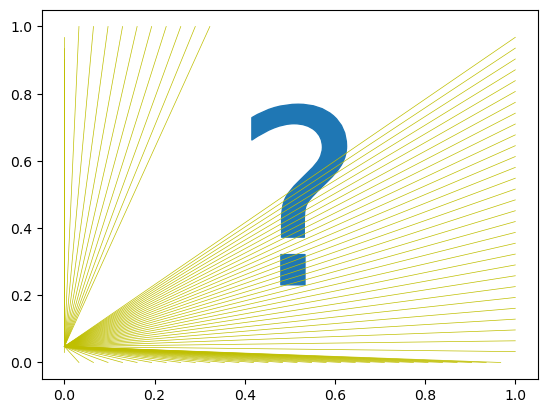

In [4]:
# linear_tomo_example.plot_model(linear_tomo_example.good_model, paths=True);
# linear_tomo_example.plot_model(linear_tomo_example.good_model);
plt.plot(0.5, 0.5, marker="$?$", markersize=130)
for p in linear_tomo_example._paths[:100]:
     plt.plot([p[0],p[2]],[p[1],p[3]],'y',linewidth=0.5)
print(' Data set contains ',len(linear_tomo_example._paths),' ray paths')

### Step 1. Define CoFI `BaseProblem`

Now we:
- set up the BaseProblem in CoFI, 
- supply it the data vector from espresso example, (i.e. the $\mathbf{d}$ vector)
- supply it the Jacobian of the linear system (i.e. the $A$ matrix)

In [5]:
linear_tomo_problem = cofi.BaseProblem()
linear_tomo_problem.set_data(linear_tomo_example.data)
linear_tomo_problem.set_jacobian(linear_tomo_example.jacobian(linear_tomo_example.starting_model)) # supply matrix A
sigma = 0.1 # set noise level of data
data_cov_inv = np.identity(linear_tomo_example.data_size) * (1/sigma**2)
linear_tomo_problem.set_data_covariance_inv(data_cov_inv)

Evaluating paths:   0%|                                                                                                    | 0/10416 [00:00<?, ?it/s]

Evaluating paths:   8%|███████▎                                                                                | 862/10416 [00:00<00:01, 8616.76it/s]

Evaluating paths:  17%|██████████████▍                                                                        | 1724/10416 [00:00<00:01, 8597.49it/s]

Evaluating paths:  25%|█████████████████████▌                                                                 | 2584/10416 [00:00<00:00, 8368.38it/s]

Evaluating paths:  33%|████████████████████████████▌                                                          | 3422/10416 [00:00<00:00, 8277.40it/s]

Evaluating paths:  41%|███████████████████████████████████▌                                                   | 4251/10416 [00:00<00:00, 8266.98it/s]

Evaluating paths:  49%|██████████████████████████████████████████▍                                            | 5078/10416 [00:00<00:00, 8247.07it/s]

Evaluating paths:  57%|█████████████████████████████████████████████████▎                                     | 5903/10416 [00:00<00:00, 8214.84it/s]

Evaluating paths:  65%|████████████████████████████████████████████████████████▏                              | 6730/10416 [00:00<00:00, 8231.23it/s]

Evaluating paths:  73%|███████████████████████████████████████████████████████████████                        | 7554/10416 [00:00<00:00, 8150.43it/s]

Evaluating paths:  80%|█████████████████████████████████████████████████████████████████████▉                 | 8375/10416 [00:01<00:00, 8166.70it/s]

Evaluating paths:  88%|████████████████████████████████████████████████████████████████████████████▉          | 9213/10416 [00:01<00:00, 8230.08it/s]

Evaluating paths:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 10040/10416 [00:01<00:00, 8239.46it/s]

Evaluating paths: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10416/10416 [00:01<00:00, 8271.23it/s]

Since $\mathbf{d}$ and $G$ have been defined then this implies a linear system. Now we choose to regularize the linear system and solve the problem 

$$ \min_{\mathbf s} \phi({\mathbf d},{\mathbf s}) = ({\mathbf d} - A {\mathbf s})^T C_d^{-1} ({\mathbf d} - A {\mathbf s})~ + ~ \lambda ~{\mathbf s}D^TD{\mathbf s}$$

The matrix system we are solving is 

$$
(\mathbf{A}^T \textbf{C}_d^{-1} \textbf{A} + \lambda \mathbf D^T\mathbf D) \textbf{s} = \textbf{A}^T \mathbf C_d^{-1} \textbf{d}
$$

In [6]:
# set up regularization
lamda = 0.5   # choose regularization constant
reg_damping = lamda * cofi.utils.QuadraticReg(
    model_shape=(linear_tomo_example.model_size,)
)
linear_tomo_problem.set_regularization(reg_damping)
print('Number of slowness parameters to be solved for = ',linear_tomo_example.model_size)

Number of slowness parameters to be solved for =  2500


and lets print a summary of the set up.

In [7]:
linear_tomo_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: Unknown
---------------------------------------------------------------------
List of functions/properties set by you:
['jacobian', 'regularization', 'data', 'data_covariance_inv']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['jacobian_times_vector']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian_times_vector', 'data_misfit', 'regularization_matrix', 'forward', 'data_covariance', 'initial_model', 'model_shape', 'blobs_dtype', 'bounds', 'constraints']


### Step 2. Define CoFI `InversionOptions`

Here we choose the backend tool for solving the tomographic system, which is scipy's least squares solver.

In [8]:
tomo_options = cofi.InversionOptions()
tomo_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

In [9]:
tomo_inv = cofi.Inversion(linear_tomo_problem, tomo_options)
tomo_inv_result = tomo_inv.run()
tomo_inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
model: [1.13306453 0.86363911 1.01958229 ... 1.01319821 0.8615539  1.14691342]
sum_of_squared_residuals: []
effective_rank: 2500
singular_values: [373.05549274 344.05222637 344.05222637 ...   1.4576611    1.35184016
   1.35184016]
model_covariance: [[ 1.86880217e-01 -9.69914246e-02 -1.15714682e-02 ...  6.47051363e-05
  -2.09495749e-05 -2.00817961e-04]
 [-9.69914246e-02  3.02828183e-01 -6.75690464e-02 ... -4.09130322e-04
   3.44626731e-04 -2.09495749e-05]
 [-1.15714682e-02 -6.75690464e-02  2.21952501e-01 ...  3.27488527e-04
  -4.09130322e-04  6.47051363e-05]
 ...
 [ 6.47051363e-05 -4.09130322e-04  3.27488527e-04 ...  2.21952501e-01
  -6.75690464e-02 -1.15714682e-02]
 [-2.09495749e-05  3.44626731e-04 -4.09130322e-04 ... -6.75690464e-02
   3.02828183e-01 -9.69914246e-02]
 [-2.00817961e-04 -2.09495749e-05  6.47051363e-05 ... -1.15714682e-02
  -9.69914246e-02  1.86880217e-01]]


Lets plot the image to see what we got.

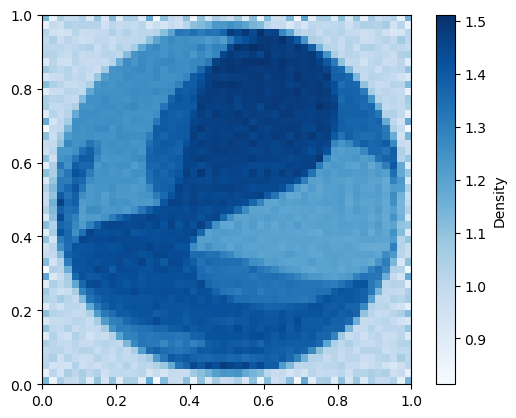

In [10]:
ax = linear_tomo_example.plot_model(tomo_inv_result.model);

### Challenge: Fewer ray paths for linear travel time

Try and construct a tomographic solution with **fewer ray paths**.

Here we use 10416 ray paths with indices 0,10415. Try a different range and see what you get.

How many ray paths do you need before the image becomes recognizable?

[![Upload to Jamboard 1](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Jamboard-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://jamboard.google.com/d/15UiYLe84zlkgLmi_ssbGuxRKyU-s4XuHSHsL8VppKJs/edit?usp=sharing)

Start from the code template below:

```
# data range
idx_from, idx_to = (<CHANGE ME>, <CHANGE ME>)

# basic settings
d = linear_tomo_example.data
G = linear_tomo_example.jacobian(linear_tomo_example.starting_model)

# now attach all the info to a BaseProblem object
mytomo = cofi.BaseProblem()
mytomo.set_data(d[idx_from:idx_to])
mytomo.set_jacobian(G[idx_from:idx_to,:])

# run your problem (with the same InversionOptions) again
mytomo_inv = cofi.Inversion(mytomo, tomo_options)
mytomo_result = mytomo_inv.run()

# check result
fig = linear_tomo_example.plot_model(mytomo_result.model)
plt.title(f'Recovered model from range ({idx_from}, {idx_to})')
plt.figure()
plt.title(' Raypaths')
for p in linear_tomo_example._paths[idx_from:idx_to]:
    plt.plot([p[0],p[2]],[p[1],p[3]],'y',linewidth=0.05)
```


In [11]:
# Copy the template above, Replace <CHANGE ME> with your answer



Evaluating paths:   0%|                                                                                                    | 0/10416 [00:00<?, ?it/s]

Evaluating paths:   8%|██████▉                                                                                 | 815/10416 [00:00<00:01, 8145.13it/s]

Evaluating paths:  16%|█████████████▊                                                                         | 1650/10416 [00:00<00:01, 8261.69it/s]

Evaluating paths:  24%|████████████████████▋                                                                  | 2477/10416 [00:00<00:00, 8130.44it/s]

Evaluating paths:  32%|███████████████████████████▍                                                           | 3291/10416 [00:00<00:00, 8093.81it/s]

Evaluating paths:  39%|██████████████████████████████████▎                                                    | 4103/10416 [00:00<00:00, 8099.29it/s]

Evaluating paths:  47%|█████████████████████████████████████████                                              | 4914/10416 [00:00<00:00, 8102.43it/s]

Evaluating paths:  55%|████████████████████████████████████████████████                                       | 5754/10416 [00:00<00:00, 8197.90it/s]

Evaluating paths:  63%|███████████████████████████████████████████████████████                                | 6592/10416 [00:00<00:00, 8252.41it/s]

Evaluating paths:  71%|██████████████████████████████████████████████████████████████                         | 7431/10416 [00:00<00:00, 8292.73it/s]

Evaluating paths:  79%|█████████████████████████████████████████████████████████████████████                  | 8261/10416 [00:01<00:00, 8257.86it/s]

Evaluating paths:  87%|████████████████████████████████████████████████████████████████████████████           | 9108/10416 [00:01<00:00, 8320.59it/s]

Evaluating paths:  96%|███████████████████████████████████████████████████████████████████████████████████▏   | 9954/10416 [00:01<00:00, 8361.59it/s]

Evaluating paths: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10416/10416 [00:01<00:00, 8256.94it/s]

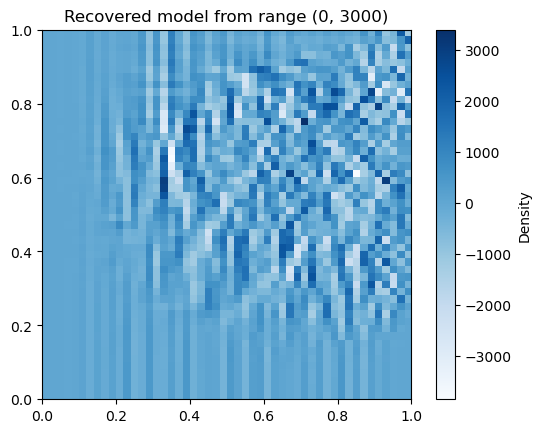

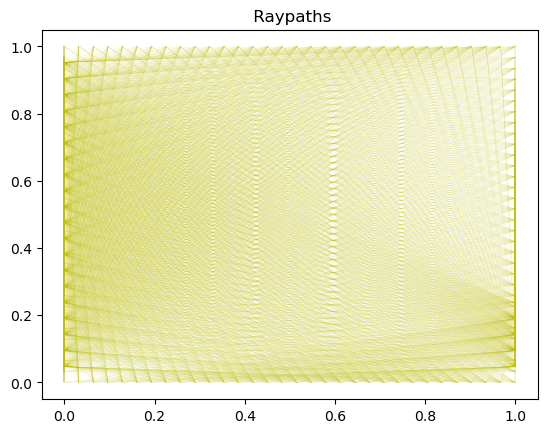

In [12]:
#@title Solution

# data range
idx_from, idx_to = (0, 3000)                    # TODO try a different range

# basic settings
d = linear_tomo_example.data
G = linear_tomo_example.jacobian(linear_tomo_example.starting_model)

# now attach all the info to a BaseProblem object
mytomo = cofi.BaseProblem()
mytomo.set_data(d[idx_from:idx_to])
mytomo.set_jacobian(G[idx_from:idx_to,:])

# run your problem (with the same InversionOptions) again
mytomo_inv = cofi.Inversion(mytomo, tomo_options)
mytomo_result = mytomo_inv.run()

# check result
fig = linear_tomo_example.plot_model(mytomo_result.model)
plt.title(f'Recovered model from range ({idx_from}, {idx_to})')
plt.figure()
plt.title(' Raypaths')
for p in linear_tomo_example._paths[idx_from:idx_to]:
    plt.plot([p[0],p[2]],[p[1],p[3]],'y',linewidth=0.05)

----------

## 2. Non-linear Travel Time Tomography

Now we demonstrate CoFI on a nonlinear iterative tomographic problem in a cross borehole setting.

We use a different tomographic example from espresso. Here we import the example module and plot the reference seismic model.

 New data set has:
 10  receivers
 10  sources
 100  travel times
 Range of travel times:  0.008911182496368759 0.0153757024856463 
 Mean travel time: 0.01085811731230709


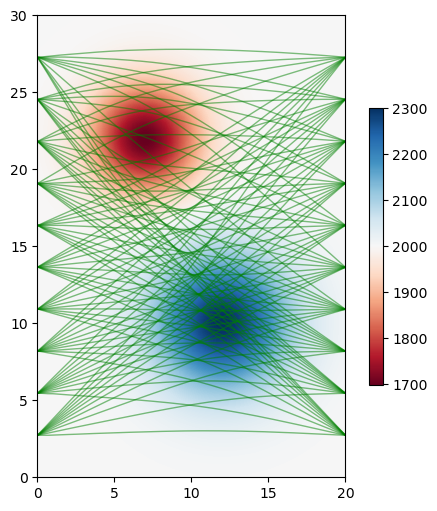

In [13]:
nonlinear_tomo_example = espresso.FmmTomography()

nonlinear_tomo_example.plot_model(nonlinear_tomo_example.good_model, with_paths=True,lw=0.5);

### Solving the tomographic system with optimization

Now we solve the tomographic system of equations using either CoFI's optimization method interface, or its iterative matrix-solver interface.

**For the optimization interface:** 

We choose an objective function of the form.

$$\phi(\mathbf{d},\mathbf{s}) = \frac{1}{\sigma^2}|| \mathbf{d} - \mathbf{g}(\mathbf{s})||_2^2 + \lambda_1 ||\mathbf{s}- \mathbf{s}_{0}||_2^2  + \lambda_2 ||D~\mathbf{s}||_2^2$$
   
where $\mathbf{g}(\mathbf{s})$ represents the predicted travel times in the slowness model $\mathbf{s}$, $\sigma^2$ is the noise variance on the travel times, $(\lambda_1,\lambda_2)$ are weights of damping and smoothing regularization terms respectively, $\mathbf{s}_{0}$ is the reference slowness model provided by the espresso example, and $D$ is a second derivative finite difference stencil for the slowness model with shape `model_shape`.

In the set up below this objective function is defined outside of CoFI in the function `objective_func` together with its gradient and Hessian, `gradient` and `hessian`  with respect to slowness parameters. For convenience the regularization terms are constructed with CoFI utility routine `QuadraticReg`. 

For the optimization case CoFI passes `objective_func` and optionally the `gradient` and `Hessian` functions to a thrid party optimization backend tool such as `scipy.minimize` to produce a solution.

**For the iterative matrix solver interface:** 

For convenience, CoFI also has its own Gauss-Newton Solver for optimization of a general objective function of the form.
$$
\phi(\mathbf{d},\mathbf{s}) = \psi((\mathbf{d},\mathbf{s}) + \sum_{r=1}^R \lambda_r \chi_r(\mathbf{s}),
$$
where $\psi$ represents a data misfit term, and $\chi_r$ one or more regularization terms, with weights $\lambda_r$. The objective function above is a special case of this. In general an iterative Gauss-Newton solver takes the form

$$ 
\mathbf{s}_{k+1} = \mathbf{s}_{k} - \cal{H}^{-1}(\mathbf{s}_k) \nabla \phi(\mathbf{s}_k), \quad {(k=0,1,\dots)},
$$

where $\cal{H}(\mathbf{s}_k)$ is the Hessian of the objective function, and $\nabla \phi(\mathbf{s}_k)$ its gradient evaluated at the model $\mathbf{s}_k$.

For the objective function above this becomes the simple iterative matrix solver

$$ \mathbf{s}_{k+1} = \mathbf{s}_k + (A^T C_d^{-1}A + \lambda_2\mathbf{I} +\lambda_2D^TD )^{-1} [A^T C_d^{-1} (\mathbf{d} - g(\mathbf{s}_k)) -  \lambda_2 (\mathbf{s - s}_{0}) - \lambda_2 D^TD \mathbf{s}], \quad (k=0,1,\dots)$$

with $C_d^{-1} = \sigma^{-2} I$.


### Step 1. Define CoFI `BaseProblem`

In [14]:
# get problem information from  espresso FmmTomography
model_size = nonlinear_tomo_example.model_size               # number of model parameters
model_shape = nonlinear_tomo_example.model_shape             # 2D spatial grid shape
data_size = nonlinear_tomo_example.data_size                 # number of data points
ref_start_slowness = nonlinear_tomo_example.starting_model   # use the starting guess supplied by the espresso example

Here we define the baseproblem object and a starting velocity model guess.

In [15]:
# define CoFI BaseProblem
nonlinear_problem = cofi.BaseProblem()
nonlinear_problem.set_initial_model(ref_start_slowness)

Here we define regularization of the tomographic system.

In [16]:
# add regularization: damping / flattening / smoothing
damping_factor = 50
smoothing_factor = 5e3
reg_damping = damping_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape, 
    weighting_matrix="damping", 
    reference_model=ref_start_slowness
)
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
reg = reg_damping + reg_smoothing

In [17]:
def objective_func(slowness, reg, sigma, data_subset=None):
    if data_subset is None: 
        data_subset = np.arange(0, nonlinear_tomo_example.data_size)
    ttimes = nonlinear_tomo_example.forward(slowness)
    residual = nonlinear_tomo_example.data[data_subset] - ttimes[data_subset]
    data_misfit = residual.T @ residual / sigma**2
    model_reg = reg(slowness)
    return  data_misfit + model_reg

def gradient(slowness, reg, sigma, data_subset=None):
    if data_subset is None: 
        data_subset = np.arange(0, nonlinear_tomo_example.data_size)
    ttimes, A = nonlinear_tomo_example.forward(slowness, with_jacobian=True)
    ttimes = ttimes[data_subset]
    A = A[data_subset]
    data_misfit_grad = -2 * A.T @ (nonlinear_tomo_example.data[data_subset] - ttimes) / sigma**2
    model_reg_grad = reg.gradient(slowness)
    return  data_misfit_grad + model_reg_grad

def hessian(slowness, reg, sigma, data_subset=None):
    if data_subset is None: 
        data_subset = np.arange(0, nonlinear_tomo_example.data_size)
    A = nonlinear_tomo_example.jacobian(slowness)[data_subset]
    data_misfit_hess = 2 * A.T @ A / sigma**2 
    model_reg_hess = reg.hessian(slowness)
    return data_misfit_hess + model_reg_hess

In [18]:
sigma = 0.00001                   # Noise is 1.0E-4 is ~5% of standard deviation of initial travel time residuals

nonlinear_problem.set_objective(objective_func, args=[reg, sigma, None])
nonlinear_problem.set_gradient(gradient, args=[reg, sigma, None])
nonlinear_problem.set_hessian(hessian, args=[reg, sigma, None])

### Step 2. Define CoFI `InversionOptions`

In [19]:
nonlinear_options = cofi.InversionOptions()

# cofi's own simple newton's matrix-based optimization solver
nonlinear_options.set_tool("cofi.simple_newton")
nonlinear_options.set_params(num_iterations=5, step_length=1, verbose=True)

# scipy's Newton-CG solver (alternative approach with similar results)
# nonlinear_options.set_tool("scipy.optimize.minimize")
# nonlinear_options.set_params(method="Newton-CG", options={"xtol":1e-16})

In [20]:
nonlinear_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._cofi_simple_newton.CoFISimpleNewton'>` - CoFI's own solver - simple Newton's approach (for testing mainly)
References: ['https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
num_iterations = 5
step_length = 1
verbose = True
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


### Step 3. Define CoFI `Inversion` and run

Iteration #0, objective function value: 110298.7001724638


Iteration #1, objective function value: 1787.0459655957825


Iteration #2, objective function value: 121.09918298452581


Iteration #3, objective function value: 5.805217146094518


Iteration #4, objective function value: 3.853291569236922


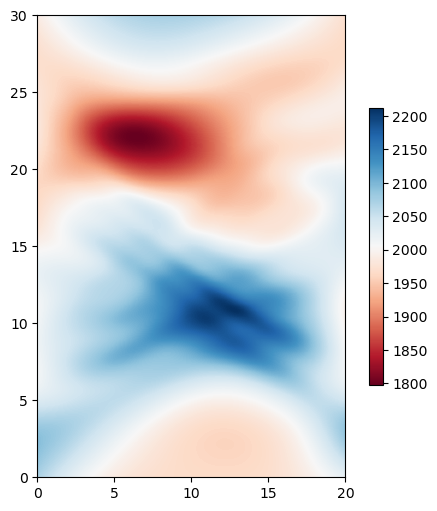

In [21]:
nonlinear_inv = cofi.Inversion(nonlinear_problem, nonlinear_options)
nonlinear_inv_result = nonlinear_inv.run()
nonlinear_tomo_example.plot_model(nonlinear_inv_result.model);

Now lets plot the true model for comparison.

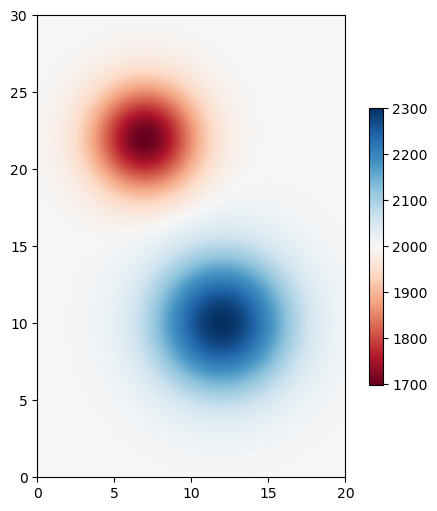

In [22]:
nonlinear_tomo_example.plot_model(nonlinear_tomo_example.good_model);

### Challenge: Change the number of tomographic data

First try and repeat this tomographic reconstruction with fewer data and see what the model looks like.

There are 100 raypaths in the full dataset and you can tell CoFI to select a subset by passing an additional
array of indices to the functions that calculate objective, gradient and hessian.

[![Upload to Jamboard 2](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Jamboard-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://jamboard.google.com/d/1TlHvC6_vHLDaZzWT3cG2hV3KCrh3M6aoxDVAJ2RGJBw/edit?usp=sharing)

Start from the code template below:

```
# Set a subset of raypaths here
data_subset = np.arange(<CHANGE ME>)

# select BaseProblem
my_own_nonlinear_problem = cofi.BaseProblem()
my_own_nonlinear_problem.set_objective(objective_func, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_gradient(gradient, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_hessian(hessian, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_initial_model(ref_start_slowness)

# run inversion with same options as previously
my_own_inversion = cofi.Inversion(my_own_nonlinear_problem, nonlinear_options)
my_own_result = my_own_inversion.run()

# check results
my_own_result.summary()

# plot inverted model
fig, paths = nonlinear_tomo_example.plot_model(my_own_result.model, return_paths=True)
print(f"Number of paths used: {len(data_subset)}")

# plot paths used
for p in np.array(paths, dtype=object)[data_subset]:
    fig.axes[0].plot(p[:,0], p[:,1], "g", alpha=0.5,lw=0.5)
```

In [23]:
# Copy the template above, Replace <CHANGE ME> with your answer



Iteration #0, objective function value: 33804.23569764485


Iteration #1, objective function value: 133.39103446819405


Iteration #2, objective function value: 2.5744622153044543


Iteration #3, objective function value: 0.4158649934434247


Iteration #4, objective function value: 0.004439988030512369


Summary for inversion result
SUCCESS
----------------------------
model: [0.00050057 0.00050052 0.00050046 ... 0.00051289 0.00051088 0.00050873]
num_iterations: 4
objective_val: 0.00048264614635943774
n_obj_evaluations: 5
n_grad_evaluations: 5
n_hess_evaluations: 5


Number of paths used: 30


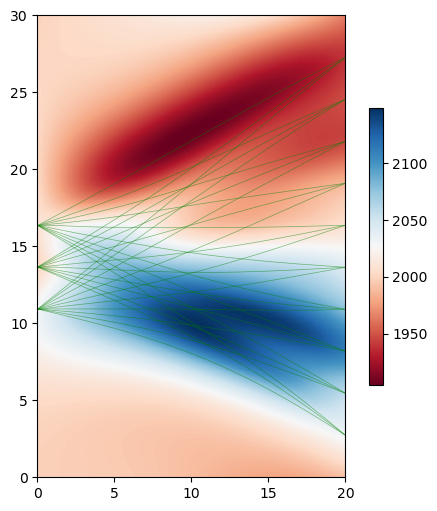

In [24]:
#@title Solution

# Set a subset of raypaths here
data_subset = np.arange(30, 60)

# select BaseProblem
my_own_nonlinear_problem = cofi.BaseProblem()
my_own_nonlinear_problem.set_objective(objective_func, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_gradient(gradient, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_hessian(hessian, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_initial_model(ref_start_slowness)

# run inversion with same options as previously
my_own_inversion = cofi.Inversion(my_own_nonlinear_problem, nonlinear_options)
my_own_result = my_own_inversion.run()

# check results
my_own_result.summary()

# plot inverted model
fig, paths = nonlinear_tomo_example.plot_model(my_own_result.model, return_paths=True)
print(f"Number of paths used: {len(data_subset)}")

# plot paths used
for p in np.array(paths, dtype=object)[data_subset]:
    fig.axes.plot(p[:,0], p[:,1], "g", alpha=0.5,lw=0.5)

### Challenge: Change regularization settings

In the solution above we used `damping_factor = 50`, and `smoothing_factor = 5.0E-3` and `flattening_factor = 0`.

Experiment with these choices, e.g increasing all of them to say 100 and repeat the tomographic solution to see how the model changes.

Try to turn off smoothing all together but retain damping and flattening and see what happens.

With some choices you can force an under-determined problem which is not solvable.

(Note that here we revert back to using all of the data by removing the `data_subset` argument to the objective function.)

To repeat this solver with other settings for smoothing and damping strength. See the documentation for [cofi.utils.QuadraticReg](https://cofi.readthedocs.io/en/latest/api/generated/cofi.utils.QuadraticReg.html).

[![Upload to Jamboard 3](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Jamboard-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://jamboard.google.com/d/15FrdSczK_TK_COOLxfSJZ5CWMzH3qMoQKySJTAp5n-4/edit?usp=sharing)

You can start from the template below:

```
# change the combination of damping, flattening and smoothing regularizations
damping_factor = <CHANGE ME>                # select damping factor here to force solution toward reference slowness model 
flattening_factor = <CHANGE ME>             # increase flattening factor here to force small first derivatives in slowness solution
smoothing_factor = <CHANGE ME>              # increase smoothing factor here to force small second derivatives in slowness solution

reg_damping = damping_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="damping",
    reference_model=ref_start_slowness
)
reg_flattening = flattening_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="flattening"
)
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
my_own_reg = reg_damping + reg_flattening + reg_smoothing

# set Baseproblem
my_own_nonlinear_problem = cofi.BaseProblem()
my_own_nonlinear_problem.set_objective(objective_func, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_gradient(gradient, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_hessian(hessian, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_initial_model(ref_start_slowness.copy())

# run inversion with same options as previously
my_own_inversion = cofi.Inversion(my_own_nonlinear_problem, nonlinear_options)
my_own_result = my_own_inversion.run()

# check results
fig = nonlinear_tomo_example.plot_model(my_own_result.model)
fig.suptitle(f"Damping {damping_factor}, Flattening {flattening_factor}, Smoothing {smoothing_factor}");
```

In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Iteration #0, objective function value: 110298.7001724638


Iteration #1, objective function value: 17978.18529996893


Iteration #2, objective function value: 20381.924100291555


Iteration #3, objective function value: 3922283196405.008


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Iteration #4, objective function value: 4.675136163574324e+16


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


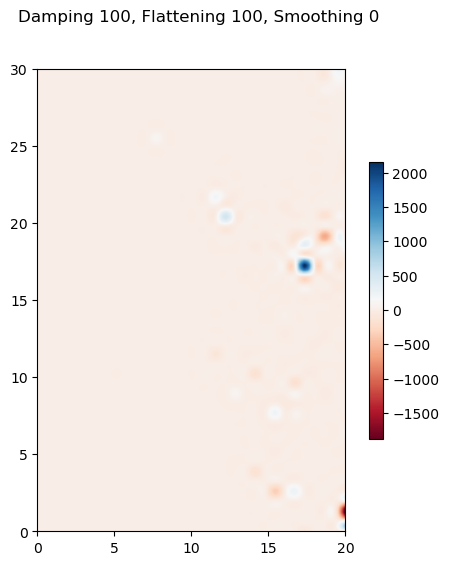

In [26]:
#@title Reference Solution

# change the combination of damping, flattening and smoothing regularizations
damping_factor = 100                # select damping factor here to force solution toward reference slowness model 
flattening_factor = 100             # increase flattening factor here to force small first derivatives in slowness solution
smoothing_factor = 0                # increase smoothing factor here to force small second derivatives in slowness solution

reg_damping = damping_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="damping",
    reference_model=ref_start_slowness
)
reg_flattening = flattening_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="flattening"
)
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
my_own_reg = reg_damping + reg_flattening + reg_smoothing

# set Baseproblem
my_own_nonlinear_problem = cofi.BaseProblem()
my_own_nonlinear_problem.set_objective(objective_func, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_gradient(gradient, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_hessian(hessian, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_initial_model(ref_start_slowness.copy())

# run inversion with same options as previously
my_own_inversion = cofi.Inversion(my_own_nonlinear_problem, nonlinear_options)
my_own_result = my_own_inversion.run()

# check results
ax = nonlinear_tomo_example.plot_model(my_own_result.model)
ax.get_figure().suptitle(f"Damping {damping_factor}, Flattening {flattening_factor}, Smoothing {smoothing_factor}");

---

## Watermark

In [27]:
watermark_list = ["cofi", "espresso", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.0
espresso 0.3.7
numpy 1.23.5
scipy 1.10.1
matplotlib 3.7.1
